# Import Libraries

In [1]:
from gnews import GNews
from datetime import datetime, timedelta
import pandas as pd
import os
import re
import numpy as np
from sklearn import svm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpstemmer import MPStemmer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import string
import pickle
import random
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM,GRU, SimpleRNN, Dense, Dropout
import tensorflow as tf
import tvDatafeed as tvd
import json
import talib
from talib import abstract
from collections import Counter

09/09/2024 12:11:43 PM - NumExpr defaulting to 8 threads.


# Global Variables

In [2]:
START_DATE = datetime.strptime('25-09-2018', "%d-%m-%Y")
END_DATE = datetime.strptime('25-09-2023', "%d-%m-%Y")
MAX_RES = 100
SITES_DICT = {
    'Bisnis.com': ('Bisnis', 'https://market.bisnis.com'),
    'CNBC Indonesia': ('CNBC', 'https://www.cnbcindonesia.com'),
    'Investor.ID': ('Investor', 'https://investor.id'),
    'Investasi Kontan' : ('Kontan', 'https://investasi.kontan.co.id')}
EMITEN = 'BMRI'
STOPWORDS_ID = StopWordRemoverFactory().create_stop_word_remover()
TARGET_DAY = 50

# Functions

## Data Collection Functions

### Function for News Extraction

In [89]:
def get_keywords_content_list(url):
    google_news = GNews(country="ID", language="id")
    article = google_news.get_full_article(url)
    article.nlp()
    keywords = article.keywords
    content = article.text
    return keywords, content

In [90]:
def gnews_getnews(start_date, end_date, max_res, site, emiten, country='ID', lang='id'):
    iteration = 1
    all_news = []
    temp_start = end_date - timedelta(days=max_res)
    while start_date < temp_start:
        
        print(f"Number of iteration = {iteration}")
        google_news = GNews(country=country, language=lang, start_date=temp_start, end_date=end_date, max_results=max_res)
        news = google_news.get_news(f"site:{site} {emiten}")
        for news_item in news:
            temp_date = re.search(r"\d{2}\s+\w{3}\s+\d{4}", news_item['published date'])[0]
            news_item['published date'] = datetime.strptime(temp_date, "%d %b %Y")
            if site != 'https://investor.id':
                news_item['keywords'], news_item['content'] = get_keywords_content_list(news_item['url'])
            else:
                news_item['keywords'], news_item['content'] = 'Missing', 'Missing'

        news = sorted(news, key=lambda x: x["published date"], reverse=True)
        all_news.extend(news)
        end_date = temp_start
        temp_start = temp_start - timedelta(days=max_res)
        iteration += 1
    print(f"Total data from {start_date} to {end_date} = {len(all_news)}")

    all_news = pd.DataFrame.from_dict(all_news)
    return all_news

## Data Preproces Functions

### Function for Text Preprocessing

In [91]:
def preprocess_title(row):
    sentence = row["title"]
    for publisher in SITES_DICT.keys():
        sentence = re.sub(publisher, " ", sentence)
    #remove numbers
    sentence = re.sub(r"\d+", "", sentence)
    #remove punctuation
    sentence = sentence.translate(str.maketrans("","",string.punctuation))
    #remove whitespace leading & trailing
    sentence = sentence.strip()
    #remove multiple whitespace into single whitespace
    sentence = re.sub('\s+',' ',sentence)
    #case folding
    sentence = sentence.lower()
    #tokenize
    #remove stopwords
    sentence = STOPWORDS_ID.remove(sentence)
    #stemming
    stemmer = MPStemmer()
    sentence = stemmer.stem_kalimat(sentence)

    return sentence

## Data Labelling Functions

### Function for Buy/Sell Labelling

In [92]:
def buysell_target(dataframe, days, price_col, percent_threshold):
    # dataframe = dataframe.assign(target_days='None')
    target = 'None'
    chg = 0
    for i in range(dataframe.shape[0] - days):
        tod_price = dataframe.loc[i, price_col]
        fut_price = dataframe.loc[i + days, price_col] 
        chg = ((fut_price - tod_price) / tod_price) * 100
        if fut_price > tod_price and chg >= percent_threshold:
            target = "buy"
        elif fut_price < tod_price and abs(chg) >= percent_threshold:
            target = "sell"
        elif abs(chg) < percent_threshold:
            target = 'hold'
        dataframe.loc[i, f"target_{days}"] = target
    return dataframe

## Functions for Price Predictions Labelling

In [93]:
def close_target(dataframe, days, price_col):
    # dataframe = dataframe.assign(target_days='None')
    target = 'None'
    for i in range(dataframe.shape[0] - days):
        target = dataframe.loc[i + days, price_col] 
        dataframe.loc[i, f"close_{days}"] = target
    return dataframe

### Function for Pseudolabelling

In [94]:
def pseudolabelling(labelled_df, unlabelled_df, lower_threshold, psd_train_size, psd_test_size, psd_pipeline_model):

    # le = LabelEncoder()
    # le.fit(['negative', 'neutral', 'positive'])
    unlabelled_df.assign(sentiment= np.nan)
    psd_train_size = labelled_df.shape[0]
    psd_test_size = unlabelled_df.shape[0]

    temp_test_size = unlabelled_df.shape[0]
    threshold_acc_dict = {}
    threshold_iteration_dict = {}
    itera = 1
    proba_threshold = 0.95

    while(temp_test_size >= 1):
        proba_threshold = 0.95
        classifier = psd_pipeline_model

        y_proba = classifier.predict_proba(unlabelled_df['cleaned']) 
        index_label_proba = np.where(np.max(y_proba, axis=1) >= proba_threshold)[0]
        while(len(index_label_proba) < 1):
            proba_threshold = proba_threshold - 0.050
            index_label_proba = np.where(np.max(y_proba, axis=1) >= proba_threshold)[0]
            
        if proba_threshold < lower_threshold:
            return labelled_df, threshold_acc_dict, threshold_iteration_dict, classifier
                    
        index_label_proba_df = unlabelled_df.iloc[index_label_proba].index
        label_proba = np.argmax(y_proba[index_label_proba], axis=1)
        # label_proba = le.inverse_transform(label_proba)
        try:
            threshold_acc_dict[proba_threshold] += len(label_proba)
        except Exception:
            threshold_acc_dict[proba_threshold] = len(label_proba)

        for i in range(len(index_label_proba)):
            unlabelled_df.loc[index_label_proba_df[i], 'sentiment'] = label_proba[i]
        
        labelled_df = pd.concat([labelled_df, unlabelled_df.loc[index_label_proba_df]])
        unlabelled_df = unlabelled_df.drop(index_label_proba_df)
        temp_test_size = unlabelled_df.shape[0]
        threshold_iteration_dict[itera] = (proba_threshold, labelled_df.iloc[psd_train_size:].shape[0]/psd_test_size, labelled_df.iloc[psd_train_size:].shape[0])

        if itera % 5 == 0:
            print(itera, labelled_df.iloc[psd_train_size:].shape[0]/psd_test_size, labelled_df.iloc[psd_train_size:].shape[0])

        itera += 1

    return labelled_df, threshold_acc_dict, threshold_iteration_dict, classifier

## Data Fusion Functions

### Functions to Apply Final Sentiment

In [95]:
def apply_sentiment(row):
    sentiment = "no sentiment"

    if row["positive"] > row["negative"]:
        sentiment = "positive"
    elif row["negative"] > row["positive"]:
        sentiment = "negative"
    elif row["positive"] >= 1 and row["positive"] == row["negative"]:
        sentiment = "mixed"
    return sentiment

# Data Collection

## Historical Data Collection Process

In [96]:
# Import tradingview credentials
cred_path = 'credential.json'

with open(cred_path, 'r') as f:
    cred = json.load(f)

username = cred['username'][0]
password = cred['password'][0]

tv = tvd.TvDatafeed(username, password)

In [97]:
# Count number of days
if os.path.exists(f"Raw Stock Data\{EMITEN}\Stock_{EMITEN}.csv"):
    stock_data = pd.read_csv(f"Raw Stock Data\{EMITEN}\Stock_{EMITEN}.csv")
    print(stock_data)
else:
    busday = np.busday_count((START_DATE - timedelta(days = 100)).strftime('%Y-%m-%d'), (datetime.now() - timedelta(days=1)).strftime('%Y-%m-%d'))
    busday = int((abs(busday)//100 + 1) * 100)

    # Collect Historical Data
    stock_data = tv.get_hist(symbol=EMITEN.upper(), exchange='IDX', interval=tvd.Interval.in_daily, n_bars=busday)
    stock_data.reset_index(inplace=True)
    try:
        os.makedirs(f"Raw Stock Data\{EMITEN}")
    except Exception:
        pass
    stock_data.to_csv(f"Raw Stock Data\{EMITEN}\Stock_{EMITEN}.csv", index=False)
    stock_data

                 datetime    symbol     open     high     low    close  \
0     2017-08-02 09:00:00  IDX:BMRI  3375.00  3375.00  3312.5  3318.75   
1     2017-08-03 09:00:00  IDX:BMRI  3300.00  3325.00  3275.0  3281.25   
2     2017-08-04 09:00:00  IDX:BMRI  3262.50  3331.25  3262.5  3268.75   
3     2017-08-07 09:00:00  IDX:BMRI  3262.50  3306.25  3262.5  3293.75   
4     2017-08-08 09:00:00  IDX:BMRI  3293.75  3356.25  3287.5  3356.25   
...                   ...       ...      ...      ...     ...      ...   
1695  2024-08-02 09:00:00  IDX:BMRI  6700.00  6875.00  6675.0  6800.00   
1696  2024-08-05 09:00:00  IDX:BMRI  6700.00  6725.00  6500.0  6575.00   
1697  2024-08-06 09:00:00  IDX:BMRI  6650.00  6700.00  6525.0  6625.00   
1698  2024-08-07 09:00:00  IDX:BMRI  6725.00  6775.00  6650.0  6775.00   
1699  2024-08-08 09:00:00  IDX:BMRI  6800.00  6850.00  6725.0  6800.00   

           volume  
0      65299600.0  
1      75375200.0  
2      62769600.0  
3      71766800.0  
4      5806

## News Data Collection Process

In [98]:
temp_dict = {}
temp_dict[EMITEN] = {}

## Data Collection
for site_name, site_tuple in SITES_DICT.items():
    site_shorten_name = site_tuple[0]
    site_link = site_tuple[1]
    if os.path.exists(f"Raw News Data\{EMITEN}\\news_{site_shorten_name.lower()}_{EMITEN.lower()}.csv"):
        print(f'Data for {EMITEN} at {site_shorten_name} Already Exists')
        continue
    else:
        print(f"{EMITEN} {site_name} {site_link}")
        temp_dict[EMITEN][site_shorten_name] = gnews_getnews(START_DATE, END_DATE, MAX_RES, site_link, EMITEN)

## Save data to files
for site, data in temp_dict[EMITEN].items():
    try:
        os.makedirs(f"Raw News Data\{EMITEN}")
    except Exception:
        pass
    data.to_csv(f"Raw News Data\{EMITEN}\\news_{site.lower()}_{EMITEN.lower()}.csv", index=False)
    print(f'CSVs for {EMITEN} created successfully')

del temp_dict

Data for BMRI at Bisnis Already Exists
Data for BMRI at CNBC Already Exists
Data for BMRI at Investor Already Exists
Data for BMRI at Kontan Already Exists


In [99]:
# Merge news data
path = f"Raw News Data/{EMITEN}/news_{SITES_DICT['Bisnis.com'][0].lower()}_{EMITEN.lower()}.csv"
news_data = pd.read_csv(path)
for news in SITES_DICT.keys():
    if news == 'Bisnis.com':
        continue
    else:
        temp_df = pd.read_csv(f"Raw News Data/{EMITEN}/news_{SITES_DICT[news][0].lower()}_{EMITEN.lower()}.csv")
    news_data = pd.concat([news_data, temp_df], ignore_index=True)
    
del temp_df
news_data.drop_duplicates(inplace=True)
news_data

,title,description,published date,url,publisher,keywords,content
0,Presiden Jokowi Akan Resmikan Bursa Karbon Ind...,Presiden Jokowi Akan Resmikan Bursa Karbon Ind...,2023-09-24,https://news.google.com/rss/articles/CBMieGh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['rekening', 'transaksi', 'bei', 'calon', 'res...",Presiden Jokowi akan meresmikan Bursa Karbon y...
1,"Dukung Program Pemerintah, ACE untuk Indonesia...","Dukung Program Pemerintah, ACE untuk Indonesia...",2023-09-22,https://news.google.com/rss/articles/CBMieWh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['sampah', '60', 'elektronik', 'melaksanakan',...","Smallest Font Largest Font\r\n\r\nBisnis.com, ..."
2,Saham Bank Mandiri Selangkah Lagi Menuju All T...,Saham Bank Mandiri Selangkah Lagi Menuju All T...,2023-09-21,https://news.google.com/rss/articles/CBMiaGh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['all', 'bmri', 'rabu2092023', 'selangkah', 'm...",Harga saham PT Bank Mandiri Tbk. (BMRI) terus ...
3,"Waran Terstruktur Meluncur ANTM, BBCA & GOTO M...","Waran Terstruktur Meluncur ANTM, BBCA & GOTO M...",2023-09-19,https://news.google.com/rss/articles/CBMibWh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['lembar', 'bbca', 'meluncur', 'ditawarkan', '...",Terdapat 10 waran terstruktur yang resmi terca...
4,Bappebti Terapkan Sistem Peringkat Bagi Pialan...,Bappebti Terapkan Sistem Peringkat Bagi Pialan...,2023-09-19,https://news.google.com/rss/articles/CBMifmh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['berjangka', 'pialang', 'pengawasan', 'bappeb...",Bappebti Kementerian Perdagangan (Kemendag) me...
...,...,...,...,...,...,...,...
3551,"Gemar bagi dividen, simak penghuni indeks IDX ...","Gemar bagi dividen, simak penghuni indeks IDX ...",2019-01-31,https://news.google.com/rss/articles/CBMiYWh0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['20', 'simak', 'penghuni', 'pengisi', 'idx', ...",Reporter: Wahyu Tri Rahmawati | Editor: Wahyu ...
3552,"Jadi orang terkaya kelima, Anthoni Salim memil...","Jadi orang terkaya kelima, Anthoni Salim memil...",2018-12-14,https://news.google.com/rss/articles/CBMibGh0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['triliun', 'level', 'rp', 'miliar', 'group', ...",ILUSTRASI.\r\n\r\nReporter: Rezha Hadyan | Edi...
3553,Bakrie Plantations siapkan rekstrukturisasi ut...,Bakrie Plantations siapkan rekstrukturisasi ut...,2018-11-30,https://news.google.com/rss/articles/CBMicWh0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['pendek', 'bakrie', 'triliun', 'to', '2019', ...",ILUSTRASI.\r\n\r\nReporter: Yoliawan H | Edito...
3554,"Tahan dulu jual saham Mayora (MYOR), ini alasa...","Tahan dulu jual saham Mayora (MYOR), ini alasa...",2018-11-14,https://news.google.com/rss/articles/CBMiU2h0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['tahan', 'ekspor', 'triliun', 'laba', 'kuarta...",ILUSTRASI. Le Minerale\r\n\r\nReporter: Jane A...


# Data Preprocess

## Historical Data Preprocess

In [100]:
## Drop Data Before Start Date
temp_date = str(START_DATE + timedelta(hours=9))
temp_index = stock_data[stock_data['datetime'] == temp_date].index[0]
temp_index = temp_index - 100
temp_df = stock_data.iloc[temp_index:].reset_index(drop=True)

## Drop Data After End Date
temp_date = str(END_DATE + timedelta(hours=9))
temp_index = temp_df[temp_df['datetime'] == temp_date].index[0]
temp_index = temp_index + 50
temp_df = temp_df[:temp_index + 1]

# temp_df
stock_data = temp_df.copy()
del temp_df, temp_date, temp_index

stock_data["datetime"] = stock_data["datetime"].apply(lambda x: x.replace('09:00:00', ''))
stock_data

,datetime,symbol,open,high,low,close,volume
0,2018-04-18,IDX:BMRI,3975.0,4025.0,3950.0,4025.0,28595200.0
1,2018-04-19,IDX:BMRI,4025.0,4037.5,3987.5,4025.0,36073200.0
2,2018-04-20,IDX:BMRI,4037.5,4037.5,3975.0,4000.0,51017600.0
3,2018-04-23,IDX:BMRI,3937.5,4000.0,3925.0,4000.0,62793000.0
4,2018-04-24,IDX:BMRI,4000.0,4000.0,3862.5,3862.5,49193400.0
...,...,...,...,...,...,...,...
1364,2023-11-29,IDX:BMRI,5850.0,5925.0,5825.0,5850.0,36796600.0
1365,2023-11-30,IDX:BMRI,5850.0,5925.0,5825.0,5850.0,117365000.0
1366,2023-12-01,IDX:BMRI,5850.0,5900.0,5825.0,5900.0,31365100.0
1367,2023-12-04,IDX:BMRI,5925.0,6025.0,5900.0,6000.0,66162000.0


In [101]:
## Create technical indicators
days = [5, 10, 20, 50]
for day in days:
    stock_data[f'SMA_{day}'] = talib.abstract.SMA(stock_data, timeperiod = day)
    stock_data[f'EMA_{day}'] = talib.abstract.EMA(stock_data, timeperiod = day)
stock_data['RSI'] = talib.abstract.RSI(stock_data, timeperiod = 14)
macd = talib.abstract.MACD(stock_data, fastperiod = 12, slowperiod = 26, signalperiod = 9)
stock_data['MACD'], stock_data['MACD_SIGNAL'] = macd['macd'], macd['macdsignal']
bb = talib.abstract.BBANDS(stock_data, timeperiod = 20, nbdevup = 2.0, nbdevdn = 2.0, matype = 0)
stock_data['UPPERBAND'], stock_data['MIDDLEBAND'], stock_data['LOWERBAND'] = bb['upperband'], bb['middleband'], bb['lowerband']

del macd, bb

## News Data Preprocess

In [102]:
## Preprocess text
news_data['cleaned'] = news_data.apply(lambda x: preprocess_title(x), axis=1)
news_data

,title,description,published date,url,publisher,keywords,content,cleaned
0,Presiden Jokowi Akan Resmikan Bursa Karbon Ind...,Presiden Jokowi Akan Resmikan Bursa Karbon Ind...,2023-09-24,https://news.google.com/rss/articles/CBMieGh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['rekening', 'transaksi', 'bei', 'calon', 'res...",Presiden Jokowi akan meresmikan Bursa Karbon y...,presiden jokowi resmi bursa karbon indonesia s...
1,"Dukung Program Pemerintah, ACE untuk Indonesia...","Dukung Program Pemerintah, ACE untuk Indonesia...",2023-09-22,https://news.google.com/rss/articles/CBMieWh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['sampah', '60', 'elektronik', 'melaksanakan',...","Smallest Font Largest Font\r\n\r\nBisnis.com, ...",dukung program perin ace indonesia bersih hadi...
2,Saham Bank Mandiri Selangkah Lagi Menuju All T...,Saham Bank Mandiri Selangkah Lagi Menuju All T...,2023-09-21,https://news.google.com/rss/articles/CBMiaGh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['all', 'bmri', 'rabu2092023', 'selangkah', 'm...",Harga saham PT Bank Mandiri Tbk. (BMRI) terus ...,saham bank mandiri selang all time high
3,"Waran Terstruktur Meluncur ANTM, BBCA & GOTO M...","Waran Terstruktur Meluncur ANTM, BBCA & GOTO M...",2023-09-19,https://news.google.com/rss/articles/CBMibWh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['lembar', 'bbca', 'meluncur', 'ditawarkan', '...",Terdapat 10 waran terstruktur yang resmi terca...,waran struktur luncur antm bbca goto luncur
4,Bappebti Terapkan Sistem Peringkat Bagi Pialan...,Bappebti Terapkan Sistem Peringkat Bagi Pialan...,2023-09-19,https://news.google.com/rss/articles/CBMifmh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['berjangka', 'pialang', 'pengawasan', 'bappeb...",Bappebti Kementerian Perdagangan (Kemendag) me...,bappebti terap sistem peringkat pialang jangka...
...,...,...,...,...,...,...,...,...
3551,"Gemar bagi dividen, simak penghuni indeks IDX ...","Gemar bagi dividen, simak penghuni indeks IDX ...",2019-01-31,https://news.google.com/rss/articles/CBMiYWh0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['20', 'simak', 'penghuni', 'pengisi', 'idx', ...",Reporter: Wahyu Tri Rahmawati | Editor: Wahyu ...,gemar dividen simak huni indeks idx high dividend
3552,"Jadi orang terkaya kelima, Anthoni Salim memil...","Jadi orang terkaya kelima, Anthoni Salim memil...",2018-12-14,https://news.google.com/rss/articles/CBMibGh0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['triliun', 'level', 'rp', 'miliar', 'group', ...",ILUSTRASI.\r\n\r\nReporter: Rezha Hadyan | Edi...,kaya anthoni salim milik kaya rp triliun
3553,Bakrie Plantations siapkan rekstrukturisasi ut...,Bakrie Plantations siapkan rekstrukturisasi ut...,2018-11-30,https://news.google.com/rss/articles/CBMicWh0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['pendek', 'bakrie', 'triliun', 'to', '2019', ...",ILUSTRASI.\r\n\r\nReporter: Yoliawan H | Edito...,bakrie plantations siap rekstrukturisasi utang...
3554,"Tahan dulu jual saham Mayora (MYOR), ini alasa...","Tahan dulu jual saham Mayora (MYOR), ini alasa...",2018-11-14,https://news.google.com/rss/articles/CBMiU2h0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['tahan', 'ekspor', 'triliun', 'laba', 'kuarta...",ILUSTRASI. Le Minerale\r\n\r\nReporter: Jane A...,tahan jual saham mayora myor alas


# Data Labelling

## Historical Data Labelling

In [103]:
if os.path.exists(f"Labelled Stock Data\Labelled_Stock_{EMITEN}.csv"):
    stock_data = pd.read_csv(f"Labelled Stock Data\Labelled_Stock_{EMITEN}.csv")
    print(f"Labelled Stock Data for {EMITEN} Already Exists")
else:
# target = 10
    stock_data = stock_data.iloc[50:].reset_index(drop=True)
    stock_data = buysell_target(stock_data, 1, "close", 1.5)
    stock_data = buysell_target(stock_data, 5, "close", 3)
    stock_data = buysell_target(stock_data, 10, "close", 6)
    stock_data = buysell_target(stock_data, 20, "close", 9)
    stock_data = buysell_target(stock_data, 50, "close", 11)
    unsliced_stock_data = stock_data.copy()
    # stock_data = stock_data.iloc[:-50]
    try:
        os.makedirs(f"Labelled Stock Data")
    except Exception:
        pass
    stock_data.to_csv(f"Labelled Stock Data\Labelled_Stock_{EMITEN}.csv", index=False)
stock_data

Labelled Stock Data for BMRI Already Exists


,datetime,symbol,open,high,low,close,volume,SMA_5,EMA_5,SMA_10,...,MACD,MACD_SIGNAL,UPPERBAND,MIDDLEBAND,LOWERBAND,target_1,target_5,target_10,target_20,target_50
0,2018-07-12,IDX:BMRI,3150.0,3225.0,3150.0,3225.0,69482600.0,3197.5,3214.106813,3240.00,...,-88.811669,-86.595007,3609.799574,3324.375,3038.950426,buy,hold,hold,buy,hold
1,2018-07-13,IDX:BMRI,3212.5,3325.0,3212.5,3300.0,71073600.0,3227.5,3242.737876,3227.50,...,-78.659597,-85.007925,3545.846014,3306.250,3066.653986,hold,sell,hold,buy,hold
2,2018-07-16,IDX:BMRI,3275.0,3312.5,3187.5,3275.0,57879600.0,3240.0,3253.491917,3228.75,...,-71.803591,-82.367058,3449.422703,3285.625,3121.827297,sell,hold,hold,hold,hold
3,2018-07-17,IDX:BMRI,3225.0,3237.5,3150.0,3162.5,84860000.0,3227.5,3223.161278,3228.75,...,-74.588161,-80.811279,3417.351620,3270.000,3122.648380,hold,buy,hold,hold,hold
4,2018-07-18,IDX:BMRI,3162.5,3212.5,3150.0,3200.0,46293000.0,3232.5,3215.440852,3218.75,...,-72.928343,-79.234691,3408.059266,3262.500,3116.940734,hold,hold,buy,hold,hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1314,2023-11-29,IDX:BMRI,5850.0,5925.0,5825.0,5850.0,36796600.0,5885.0,5878.063427,5887.50,...,5.933732,2.257456,5950.357767,5873.750,5797.142233,hold,NaN,NaN,NaN,NaN
1315,2023-11-30,IDX:BMRI,5850.0,5925.0,5825.0,5850.0,117365000.0,5875.0,5868.708951,5880.00,...,3.481292,2.502223,5947.530732,5871.250,5794.969268,hold,NaN,NaN,NaN,NaN
1316,2023-12-01,IDX:BMRI,5850.0,5900.0,5825.0,5900.0,31365100.0,5880.0,5879.139301,5880.00,...,5.508796,3.103537,5949.161985,5875.000,5800.838015,buy,NaN,NaN,NaN,NaN
1317,2023-12-04,IDX:BMRI,5925.0,6025.0,5900.0,6000.0,66162000.0,5900.0,5919.426201,5892.50,...,15.011725,5.485175,5968.576221,5878.750,5788.923779,hold,NaN,NaN,NaN,NaN


## News Data Labelling

In [104]:
## Open labelled data
path = 'Labelled News Data/Labelled_News_All.csv'
labelled_news_data = pd.read_csv(path)
labelled_news_data.drop(labelled_news_data.columns[0], axis=1, inplace=True)
labelled_news_data

,title,description,published date,url,publisher,keywords,content,cleaned,sentiment
0,Pundi-pundi Konglomerat di Lapak Bursa Karbon ...,Pundi-pundi Konglomerat di Lapak Bursa Karbon ...,2023-09-25,https://news.google.com/rss/articles/CBMia2h0d...,"{'href': 'https://market.bisnis.com', 'title':...","['tbk', 'energy', 'lapak', 'bren', 'indika', '...",Kekayaan konglomerat Indonesia tahun ini diper...,pundipundi konglomerat lapak bursa karbon indo...,positive
1,"Potensi Cuan Akhir Tahun dari Dividen Interim,...","Potensi Cuan Akhir Tahun dari Dividen Interim,...",2023-09-25,https://news.google.com/rss/articles/CBMiemh0d...,"{'href': 'https://www.cnbcindonesia.com', 'tit...","['potensi', 'cuan', 'membagikan', 'lembar', 'c...","Jakarta, CNBC Indonesia - Para investor yang m...",potensi cuan dividen interim cek emiten,positive
2,"Waspada IHSG Menuju Level Terendah, MYOR Hingg...","Waspada IHSG Menuju Level Terendah, MYOR Hingg...",2023-09-25,https://news.google.com/rss/articles/CBMib2h0d...,"{'href': 'https://investor.id', 'title': 'Inve...","['waspada', 'kija', 'level', 'penurunan', 'men...","JAKARTA, investor.id - Founder stocknow.id Hen...",waspada ihsg level rendah myor kija layak buru...,positive
3,"IHSG Diprediksi Lanjut Menguat, Cek Saham AKRA...","IHSG Diprediksi Lanjut Menguat, Cek Saham AKRA...",2023-09-25,https://news.google.com/rss/articles/CBMicGh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['menguat', 'on', 'diprediksi', 'level', 'akra...",MNC Sekuritas memprediksi IHSG hari ini akan m...,ihsg prediksi kuat cek saham akra mdka pgeo tlkm,positive
4,"IHSG Melemah Tipis ke 7.010,5 di Pagi Ini, TBI...","IHSG Melemah Tipis ke 7.010,5 di Pagi Ini, TBI...",2023-09-25,https://news.google.com/rss/articles/CBMib2h0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['losers', 'tbk', 'tersedia', 'tipis', 'senila...",ILUSTRASI. Indeks Harga Saham Gabungan (IHSG) ...,ihsg lemah tipis pagi tbig tlkm buka top loser...,negative
...,...,...,...,...,...,...,...,...,...
12979,"Harga jual turun, pendapatan Polychem Indonesi...","Harga jual turun, pendapatan Polychem Indonesi...",2020-05-16,https://news.google.com/rss/articles/CBMibGh0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['tpt', 'us', 'kuantitas', 'produksi', 'polych...",ILUSTRASI. Produsen bahan baku kimia PT Polych...,harga jual turun dapat polychem indonesia admg...,positive
12980,TOP LOSERS: Saham FKS Multi Agro (FISH) Anjlok...,TOP LOSERS: Saham FKS Multi Agro (FISH) Anjlok...,2019-01-31,https://news.google.com/rss/articles/CBMiaGh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['anjlok', 'poin', 'penurunan', 'top', 'terdal...",Saham PT FKS Multi Agro Tbk. (FISH) mencatat p...,top losers saham fks multi agro fish anjlok pe...,positive
12981,Buka Tabungan Valas Sedari Dini untuk Biaya Ku...,Buka Tabungan Valas Sedari Dini untuk Biaya Ku...,2023-02-23,https://news.google.com/rss/articles/CBMiamh0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['biaya', 'tabungan', 'kuliah', 'trust', '10',...",ILUSTRASI. Kontan - J Trust Bank Kilas Online\...,buka tabung valas sedari dini biaya kuliah ana...,positive
12982,"IPO, Sinar Eka Selaras Lepas 20% Saham ke Publ...","IPO, Sinar Eka Selaras Lepas 20% Saham ke Publ...",2023-07-17,https://news.google.com/rss/articles/CBMiUmh0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['erajaya', 'ritel', 'rp', 'eral', 'ipo', 'act...",PT Sinar Eka Selaras Tbk (ERAL) atau Erajaya A...,ipo sinar eka laras lepas saham publik,negative


In [105]:
## pseudolabelling
if os.path.exists(f'Labelled News Data/Labelled_News_{EMITEN}.csv'):
    news_data =  pd.read_csv(f'Labelled News Data/Labelled_News_{EMITEN}.csv')
    if news_data.columns[0] == 'Unnamed: 0':
        news_data = news_data.drop(news_data.columns[0], axis=1)
else:
    psd_train_size = labelled_news_data.shape[0]
    psd_test_size = news_data.shape[0]
    print(psd_train_size, psd_test_size)

    psd_pipeline_model = pickle.load(open('pseudolabelling_pipeline_model_pkl', 'rb'))
    pseudolabelled_news_all, threshold_acc_dict, threshold_iteration_dict, classifier = pseudolabelling(labelled_news_data, news_data, 0.68, psd_train_size, psd_test_size, psd_pipeline_model)

    ## save the new model
    pickle.dump(classifier, open('new_pseudolabelling_pipeline_model_pkl', 'wb'))

    ## visualize pseudolabelling results
    temp_list = dict(sorted(threshold_iteration_dict.items()))
    plt.figure(figsize=(15, 5))
    a, b, c = zip(*temp_list.values())

    plt.subplot(1, 3, 1)
    plt.plot(temp_list.keys(), a)
    plt.xlabel("Iteration")
    plt.ylabel("Probability Threshold")
    plt.title("Threshold per Iteration")

    plt.subplot(1, 3, 2)
    plt.plot(temp_list.keys(), b)
    plt.xlabel("Iteration")
    plt.ylabel("Data Percentage Over Unlabelled Data")
    plt.title("Acquired Data Percentage After Each Iteration")

    a = list(threshold_acc_dict.values())
    a = [a/psd_test_size for a in a]
    plt.subplot(1, 3, 3)
    plt.plot(threshold_acc_dict.keys(), a)
    plt.xlabel("Probability Threshold")
    plt.ylabel("Data Percentage Over Unlabelled Data")
    plt.title("Number of Data per Threshold")
    plt.show()

    ## slice data for EMITEN
    news_data = pseudolabelled_news_all.iloc[psd_train_size:].sort_values(by=['published date'], ascending=False)
    news_data.reset_index(drop=True, inplace=True)

    ## save data
    news_data.to_csv(f"Labelled News Data/Labelled_News_{EMITEN}.csv")
    
    ## save new all data
    temp = pseudolabelled_news_all.reset_index(drop=True)
    temp.to_csv('Labelled News Data\Labelled_News_All.csv')
    
news_data

,title,description,published date,url,publisher,keywords,content,cleaned,sentiment
0,10 Saham Ini Ramai-ramai Diborong Asing Kala I...,10 Saham Ini Ramai-ramai Diborong Asing Kala I...,2023-09-25,https://news.google.com/rss/articles/CBMid2h0d...,"{'href': 'https://www.cnbcindonesia.com', 'tit...","['net', 'investor', '10', 'level', 'diborong',...","Jakarta, CNBC Indonesia - Indeks Harga Saham G...",saham ramairamai borong asing kala ihsg kuat,positive
1,Siap-siap Bank Mandiri Mau Blokir Rekening Jud...,Siap-siap Bank Mandiri Mau Blokir Rekening Jud...,2023-09-25,https://news.google.com/rss/articles/CBMidGh0d...,"{'href': 'https://www.cnbcindonesia.com', 'tit...","['online', 'rekening', 'blokir', 'transaksi', ...","Jakarta, CNBC Indonesia - Perjudian online tel...",siapsiap bank mandiri mau blokir rekening judi...,positive
2,Saham Bank Ini Diam-diam Bisa Kasih Cuan dan D...,Saham Bank Ini Diam-diam Bisa Kasih Cuan dan D...,2023-09-25,https://news.google.com/rss/articles/CBMiZ2h0d...,"{'href': 'https://investor.id', 'title': 'Inve...",Missing,Missing,saham bank diamdiam kasih cuan dividen gede pe...,positive
3,Anak Usaha Indika (INDY) Raih Pinjaman US$ 50 ...,Anak Usaha Indika (INDY) Raih Pinjaman US$ 50 ...,2023-09-24,https://news.google.com/rss/articles/CBMia2h0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['dbs', 'kariangau', 'energi', 'indy', 'indika...",Reporter: Akhmad Suryahadi | Editor: Tendi Mah...,anak usaha indika indy raih pinjam us juta ban...,positive
4,Presiden Jokowi Akan Resmikan Bursa Karbon Ind...,Presiden Jokowi Akan Resmikan Bursa Karbon Ind...,2023-09-24,https://news.google.com/rss/articles/CBMieGh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['rekening', 'transaksi', 'bei', 'calon', 'res...",Presiden Jokowi akan meresmikan Bursa Karbon y...,presiden jokowi resmi bursa karbon indonesia s...,positive
...,...,...,...,...,...,...,...,...,...
3499,Monex Gelar Kompetisi Trading Online Kategori ...,Monex Gelar Kompetisi Trading Online Kategori ...,2018-10-31,https://news.google.com/rss/articles/CBMibWh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['online', 'pengetahuan', 'berjangka', 'mifx',...",PT Monex Investindo Futures menggelar kompetis...,monex gelar kompetisi trading online kategori ...,positive
3500,"Jadi Perusahaan Terbaik Dunia, Inilah Rahasia ...","Jadi Perusahaan Terbaik Dunia, Inilah Rahasia ...",2018-10-29,https://news.google.com/rss/articles/CBMidmh0d...,"{'href': 'https://www.cnbcindonesia.com', 'tit...","['elemen', 'generasi', 'best', 'informal', 'ma...",Pilihan Redaksi Bangga! 4 BUMN Jadi Perusahaan...,jadi usaha baik dunia ini rahasia bank mandiri,positive
3501,"Pasar Saham Global Terus Tertekan, Ini Pemicun...","Pasar Saham Global Terus Tertekan, Ini Pemicun...",2018-10-25,https://news.google.com/rss/articles/CBMiYGh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['sam', 'kuartal', 'tertekan', 'paman', 'level...",Kombinasi dari melambatnya pencapaian kinerja ...,pasar saham global terus tertekan picu,positive
3502,Bank Mandiri Masuk Daftar Teratas World's Best...,Bank Mandiri Masuk Daftar Teratas World's Best...,2018-10-24,https://news.google.com/rss/articles/CBMicWh0d...,"{'href': 'https://www.cnbcindonesia.com', 'tit...","['indonesiagita', 'to', 'cnbc', 'best', 'resum...",ADVERTISEMENT SCROLL TO RESUME CONTENT\r\n\r\n...,bank mandiri masuk daftar atas worlds best emp...,positive


# Data Fusion of Historical and News Sentiment

## Merging with Outer

In [106]:
# Rename columns
news_data.rename(columns={"published date": "datetime"}, inplace=True)

# conform data type
news_data['datetime'] = news_data['datetime'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
stock_data['datetime'] = stock_data['datetime'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d "))

In [107]:
# Merge data
merge_data = pd.merge(news_data, stock_data, on='datetime', how="outer")
merge_data = merge_data.drop(columns=['title', 'description', 'url', 'publisher', 'keywords', 'content', 'cleaned'])
merge_data.sort_values(by=["datetime"], ascending=True, inplace=True)
merge_data.reset_index(inplace=True, drop=True)
merge_data

,datetime,sentiment,symbol,open,high,low,close,volume,SMA_5,EMA_5,...,MACD,MACD_SIGNAL,UPPERBAND,MIDDLEBAND,LOWERBAND,target_1,target_5,target_10,target_20,target_50
0,2018-07-12,NaN,IDX:BMRI,3150.0,3225.0,3150.0,3225.0,69482600.0,3197.5,3214.106813,...,-88.811669,-86.595007,3609.799574,3324.375,3038.950426,buy,hold,hold,buy,hold
1,2018-07-13,NaN,IDX:BMRI,3212.5,3325.0,3212.5,3300.0,71073600.0,3227.5,3242.737876,...,-78.659597,-85.007925,3545.846014,3306.250,3066.653986,hold,sell,hold,buy,hold
2,2018-07-16,NaN,IDX:BMRI,3275.0,3312.5,3187.5,3275.0,57879600.0,3240.0,3253.491917,...,-71.803591,-82.367058,3449.422703,3285.625,3121.827297,sell,hold,hold,hold,hold
3,2018-07-17,NaN,IDX:BMRI,3225.0,3237.5,3150.0,3162.5,84860000.0,3227.5,3223.161278,...,-74.588161,-80.811279,3417.351620,3270.000,3122.648380,hold,buy,hold,hold,hold
4,2018-07-18,NaN,IDX:BMRI,3162.5,3212.5,3150.0,3200.0,46293000.0,3232.5,3215.440852,...,-72.928343,-79.234691,3408.059266,3262.500,3116.940734,hold,hold,buy,hold,hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,2023-11-29,NaN,IDX:BMRI,5850.0,5925.0,5825.0,5850.0,36796600.0,5885.0,5878.063427,...,5.933732,2.257456,5950.357767,5873.750,5797.142233,hold,NaN,NaN,NaN,NaN
3768,2023-11-30,NaN,IDX:BMRI,5850.0,5925.0,5825.0,5850.0,117365000.0,5875.0,5868.708951,...,3.481292,2.502223,5947.530732,5871.250,5794.969268,hold,NaN,NaN,NaN,NaN
3769,2023-12-01,NaN,IDX:BMRI,5850.0,5900.0,5825.0,5900.0,31365100.0,5880.0,5879.139301,...,5.508796,3.103537,5949.161985,5875.000,5800.838015,buy,NaN,NaN,NaN,NaN
3770,2023-12-04,NaN,IDX:BMRI,5925.0,6025.0,5900.0,6000.0,66162000.0,5900.0,5919.426201,...,15.011725,5.485175,5968.576221,5878.750,5788.923779,hold,NaN,NaN,NaN,NaN


## Agregate Sentiment

In [108]:
temp_2 = merge_data[["datetime", "sentiment"]]
temp_2 = temp_2.groupby(["datetime", "sentiment"]).size().to_frame("agg")
temp_2 = temp_2.pivot_table(values="agg", index=["datetime"], columns="sentiment")
temp_2.reset_index(inplace=True)
temp_2

sentiment,datetime,negative,positive
0,2018-10-22,NaN,1.0
1,2018-10-24,NaN,1.0
2,2018-10-25,NaN,1.0
3,2018-10-29,NaN,1.0
4,2018-10-31,NaN,1.0
...,...,...,...
1337,2023-09-20,1.0,3.0
1338,2023-09-21,NaN,4.0
1339,2023-09-22,NaN,3.0
1340,2023-09-24,NaN,2.0


In [109]:
merge_data.drop_duplicates(subset='datetime', keep="first", inplace=True)
merge_data.drop(columns=["sentiment"], inplace=True)
merge_data.reset_index(inplace=True, drop=True)
merge_data = pd.merge(merge_data, temp_2, on='datetime', how='left')
merge_data

,datetime,symbol,open,high,low,close,volume,SMA_5,EMA_5,SMA_10,...,UPPERBAND,MIDDLEBAND,LOWERBAND,target_1,target_5,target_10,target_20,target_50,negative,positive
0,2018-07-12,IDX:BMRI,3150.0,3225.0,3150.0,3225.0,69482600.0,3197.5,3214.106813,3240.00,...,3609.799574,3324.375,3038.950426,buy,hold,hold,buy,hold,NaN,NaN
1,2018-07-13,IDX:BMRI,3212.5,3325.0,3212.5,3300.0,71073600.0,3227.5,3242.737876,3227.50,...,3545.846014,3306.250,3066.653986,hold,sell,hold,buy,hold,NaN,NaN
2,2018-07-16,IDX:BMRI,3275.0,3312.5,3187.5,3275.0,57879600.0,3240.0,3253.491917,3228.75,...,3449.422703,3285.625,3121.827297,sell,hold,hold,hold,hold,NaN,NaN
3,2018-07-17,IDX:BMRI,3225.0,3237.5,3150.0,3162.5,84860000.0,3227.5,3223.161278,3228.75,...,3417.351620,3270.000,3122.648380,hold,buy,hold,hold,hold,NaN,NaN
4,2018-07-18,IDX:BMRI,3162.5,3212.5,3150.0,3200.0,46293000.0,3232.5,3215.440852,3218.75,...,3408.059266,3262.500,3116.940734,hold,hold,buy,hold,hold,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1605,2023-11-29,IDX:BMRI,5850.0,5925.0,5825.0,5850.0,36796600.0,5885.0,5878.063427,5887.50,...,5950.357767,5873.750,5797.142233,hold,NaN,NaN,NaN,NaN,NaN,NaN
1606,2023-11-30,IDX:BMRI,5850.0,5925.0,5825.0,5850.0,117365000.0,5875.0,5868.708951,5880.00,...,5947.530732,5871.250,5794.969268,hold,NaN,NaN,NaN,NaN,NaN,NaN
1607,2023-12-01,IDX:BMRI,5850.0,5900.0,5825.0,5900.0,31365100.0,5880.0,5879.139301,5880.00,...,5949.161985,5875.000,5800.838015,buy,NaN,NaN,NaN,NaN,NaN,NaN
1608,2023-12-04,IDX:BMRI,5925.0,6025.0,5900.0,6000.0,66162000.0,5900.0,5919.426201,5892.50,...,5968.576221,5878.750,5788.923779,hold,NaN,NaN,NaN,NaN,NaN,NaN


## Aggregate Data Holidays

In [110]:
values = {"negative": 0, "positive": 0}
merge_data.fillna(value = values, inplace=True)

# Add values from holiday dates to business dates
holidays = merge_data[merge_data["symbol"].isnull()].index
for ind in holidays:
    i = 1
    while(pd.isnull(merge_data.loc[ind + i, "symbol"])):
        i += 1
    merge_data.loc[ind + i, "negative"] += merge_data.loc[ind, "negative"]
    merge_data.loc[ind + i, "positive"] += merge_data.loc[ind, "positive"]
    merge_data.drop([ind], axis=0, inplace=True)

merge_data.reset_index(inplace=True, drop=True)
merge_data["total_news"] = merge_data["negative"] + merge_data["positive"]
merge_data

,datetime,symbol,open,high,low,close,volume,SMA_5,EMA_5,SMA_10,...,MIDDLEBAND,LOWERBAND,target_1,target_5,target_10,target_20,target_50,negative,positive,total_news
0,2018-07-12,IDX:BMRI,3150.0,3225.0,3150.0,3225.0,69482600.0,3197.5,3214.106813,3240.00,...,3324.375,3038.950426,buy,hold,hold,buy,hold,0.0,0.0,0.0
1,2018-07-13,IDX:BMRI,3212.5,3325.0,3212.5,3300.0,71073600.0,3227.5,3242.737876,3227.50,...,3306.250,3066.653986,hold,sell,hold,buy,hold,0.0,0.0,0.0
2,2018-07-16,IDX:BMRI,3275.0,3312.5,3187.5,3275.0,57879600.0,3240.0,3253.491917,3228.75,...,3285.625,3121.827297,sell,hold,hold,hold,hold,0.0,0.0,0.0
3,2018-07-17,IDX:BMRI,3225.0,3237.5,3150.0,3162.5,84860000.0,3227.5,3223.161278,3228.75,...,3270.000,3122.648380,hold,buy,hold,hold,hold,0.0,0.0,0.0
4,2018-07-18,IDX:BMRI,3162.5,3212.5,3150.0,3200.0,46293000.0,3232.5,3215.440852,3218.75,...,3262.500,3116.940734,hold,hold,buy,hold,hold,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1314,2023-11-29,IDX:BMRI,5850.0,5925.0,5825.0,5850.0,36796600.0,5885.0,5878.063427,5887.50,...,5873.750,5797.142233,hold,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1315,2023-11-30,IDX:BMRI,5850.0,5925.0,5825.0,5850.0,117365000.0,5875.0,5868.708951,5880.00,...,5871.250,5794.969268,hold,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1316,2023-12-01,IDX:BMRI,5850.0,5900.0,5825.0,5900.0,31365100.0,5880.0,5879.139301,5880.00,...,5875.000,5800.838015,buy,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1317,2023-12-04,IDX:BMRI,5925.0,6025.0,5900.0,6000.0,66162000.0,5900.0,5919.426201,5892.50,...,5878.750,5788.923779,hold,NaN,NaN,NaN,NaN,0.0,0.0,0.0


## Apply Final Sentiment

In [111]:
merge_data["sentiment"] = merge_data.apply(lambda x: apply_sentiment(x), axis=1)
merge_data

,datetime,symbol,open,high,low,close,volume,SMA_5,EMA_5,SMA_10,...,LOWERBAND,target_1,target_5,target_10,target_20,target_50,negative,positive,total_news,sentiment
0,2018-07-12,IDX:BMRI,3150.0,3225.0,3150.0,3225.0,69482600.0,3197.5,3214.106813,3240.00,...,3038.950426,buy,hold,hold,buy,hold,0.0,0.0,0.0,no sentiment
1,2018-07-13,IDX:BMRI,3212.5,3325.0,3212.5,3300.0,71073600.0,3227.5,3242.737876,3227.50,...,3066.653986,hold,sell,hold,buy,hold,0.0,0.0,0.0,no sentiment
2,2018-07-16,IDX:BMRI,3275.0,3312.5,3187.5,3275.0,57879600.0,3240.0,3253.491917,3228.75,...,3121.827297,sell,hold,hold,hold,hold,0.0,0.0,0.0,no sentiment
3,2018-07-17,IDX:BMRI,3225.0,3237.5,3150.0,3162.5,84860000.0,3227.5,3223.161278,3228.75,...,3122.648380,hold,buy,hold,hold,hold,0.0,0.0,0.0,no sentiment
4,2018-07-18,IDX:BMRI,3162.5,3212.5,3150.0,3200.0,46293000.0,3232.5,3215.440852,3218.75,...,3116.940734,hold,hold,buy,hold,hold,0.0,0.0,0.0,no sentiment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1314,2023-11-29,IDX:BMRI,5850.0,5925.0,5825.0,5850.0,36796600.0,5885.0,5878.063427,5887.50,...,5797.142233,hold,NaN,NaN,NaN,NaN,0.0,0.0,0.0,no sentiment
1315,2023-11-30,IDX:BMRI,5850.0,5925.0,5825.0,5850.0,117365000.0,5875.0,5868.708951,5880.00,...,5794.969268,hold,NaN,NaN,NaN,NaN,0.0,0.0,0.0,no sentiment
1316,2023-12-01,IDX:BMRI,5850.0,5900.0,5825.0,5900.0,31365100.0,5880.0,5879.139301,5880.00,...,5800.838015,buy,NaN,NaN,NaN,NaN,0.0,0.0,0.0,no sentiment
1317,2023-12-04,IDX:BMRI,5925.0,6025.0,5900.0,6000.0,66162000.0,5900.0,5919.426201,5892.50,...,5788.923779,hold,NaN,NaN,NaN,NaN,0.0,0.0,0.0,no sentiment


## Sentiment Visualization

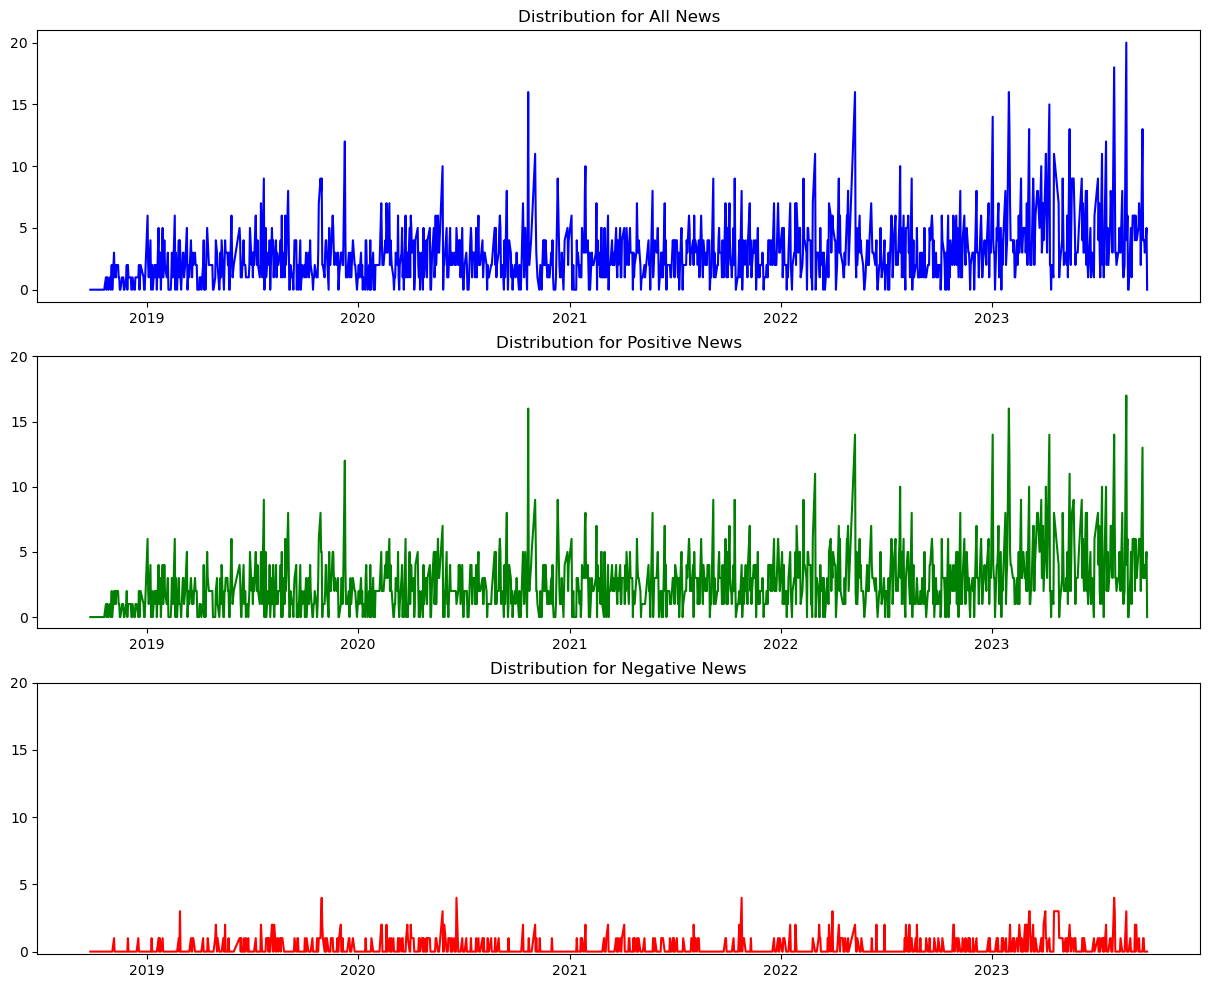

In [112]:
plt.figure(figsize=(15, 12))

plt.subplot(3, 1, 1)
plt.plot(merge_data.loc[50:merge_data.shape[0]-50, 'datetime'], merge_data.loc[50:merge_data.shape[0]-50, 'total_news'], color='blue')
plt.yticks(np.arange(0, merge_data['total_news'].max() + 1, 5))
plt.title('Distribution for All News')

plt.subplot(3, 1, 2)
plt.plot(merge_data.loc[50:merge_data.shape[0]-50, 'datetime'], merge_data.loc[50:merge_data.shape[0]-50, 'positive'], color='green')
plt.yticks(np.arange(0, merge_data['total_news'].max() + 1, 5))
plt.title('Distribution for Positive News')


plt.subplot(3, 1, 3)
plt.plot(merge_data.loc[50:merge_data.shape[0]-50, 'datetime'], merge_data.loc[50:merge_data.shape[0]-50, 'negative'], color='red')
plt.yticks(np.arange(0, merge_data['total_news'].max() + 1, 5))
plt.title('Distribution for Negative News')

plt.show()

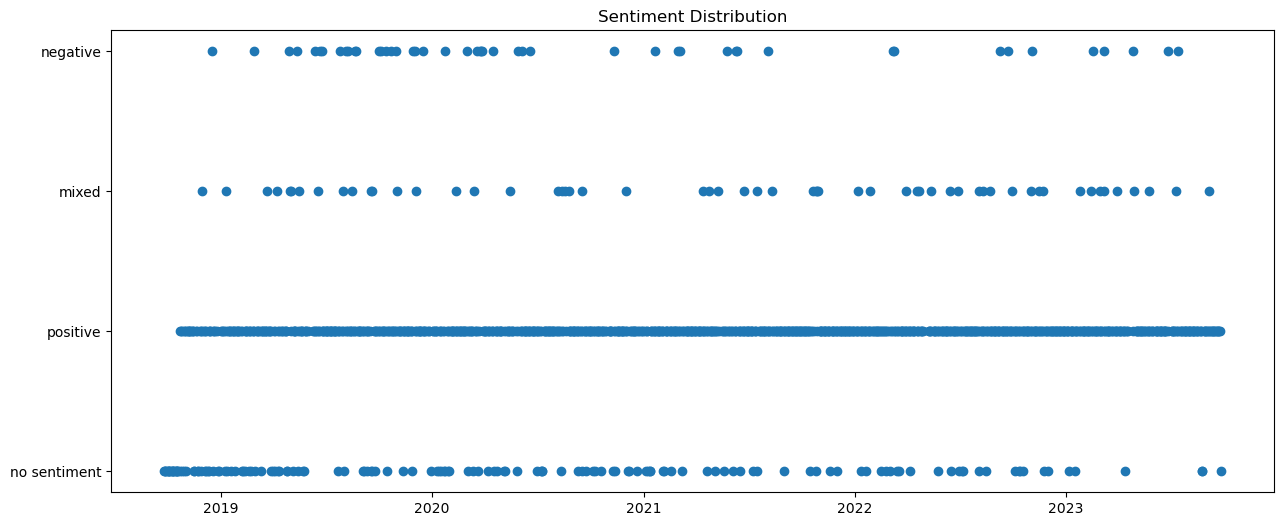

In [113]:
plt.figure(figsize=(15, 6))

plt.scatter(merge_data.loc[50:merge_data.shape[0]-50, 'datetime'], merge_data.loc[50:merge_data.shape[0]-50, 'sentiment'])
plt.title('Sentiment Distribution')
plt.show()

In [114]:
merge_data.loc[:, 'sentiment'].value_counts()

sentiment
positive        967
no sentiment    247
mixed            57
negative         48
Name: count, dtype: int64

## Label Encoding for Final Sentiment and Buy/Sell Label

In [115]:
le = LabelEncoder()
le.classes_ = np.array(["negative", "no sentiment", "mixed", "positive"])
merge_data["sentiment"] = le.transform(merge_data["sentiment"]) - 1

merge_data = merge_data.iloc[:-50]
target_columns = ['target_1',
                  'target_5',
                  'target_10',
                  'target_20',
                  'target_50']
le.classes_ = np.array(["sell", "hold", "buy"])
for col in target_columns:
    merge_data.loc[:, col] = le.transform(merge_data.loc[:, col])

try:
    os.makedirs(f"Data Fusion of Historical and Sentiment")
except Exception:
    pass
merge_data.to_csv(f"Data Fusion of Historical and Sentiment\Fusion_Data_{EMITEN}.csv", index=False)

# Modelling

In [116]:
fusion_data = pd.read_csv(f'Data Fusion of Historical and Sentiment\Fusion_Data_{EMITEN}.csv')
fusion_data

,datetime,symbol,open,high,low,close,volume,SMA_5,EMA_5,SMA_10,...,LOWERBAND,target_1,target_5,target_10,target_20,target_50,negative,positive,total_news,sentiment
0,2018-07-12,IDX:BMRI,3150.0,3225.0,3150.0,3225.0,69482600.0,3197.5,3214.106813,3240.00,...,3038.950426,2,1,1,2,1,0.0,0.0,0.0,0
1,2018-07-13,IDX:BMRI,3212.5,3325.0,3212.5,3300.0,71073600.0,3227.5,3242.737876,3227.50,...,3066.653986,1,0,1,2,1,0.0,0.0,0.0,0
2,2018-07-16,IDX:BMRI,3275.0,3312.5,3187.5,3275.0,57879600.0,3240.0,3253.491917,3228.75,...,3121.827297,0,1,1,1,1,0.0,0.0,0.0,0
3,2018-07-17,IDX:BMRI,3225.0,3237.5,3150.0,3162.5,84860000.0,3227.5,3223.161278,3228.75,...,3122.648380,1,2,1,1,1,0.0,0.0,0.0,0
4,2018-07-18,IDX:BMRI,3162.5,3212.5,3150.0,3200.0,46293000.0,3232.5,3215.440852,3218.75,...,3116.940734,1,1,2,1,1,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,2023-09-19,IDX:BMRI,5900.0,6075.0,5875.0,6000.0,93889400.0,5900.0,5929.706013,5912.50,...,5786.744155,1,1,1,1,1,1.0,3.0,4.0,2
1265,2023-09-20,IDX:BMRI,6100.0,6125.0,6050.0,6075.0,64864900.0,5945.0,5978.137342,5915.00,...,5796.810640,1,1,1,1,1,1.0,3.0,4.0,2
1266,2023-09-21,IDX:BMRI,6050.0,6075.0,5975.0,6000.0,60535000.0,5980.0,5985.424895,5927.50,...,5798.712691,1,1,1,1,1,0.0,4.0,4.0,2
1267,2023-09-22,IDX:BMRI,6000.0,6050.0,5975.0,6000.0,51069900.0,5995.0,5990.283263,5937.50,...,5805.966153,1,1,1,1,1,0.0,3.0,3.0,2


## Split Features and Target

In [117]:
x = fusion_data.copy()
target_columns = ['target_1',
                  'target_5',
                  'target_10',
                  'target_20',
                  'target_50']
y = x[target_columns]

x.drop([
        'symbol',
        ], axis=1, inplace=True)

for col in target_columns:
    print(x[col].value_counts())
    x.drop([col], axis=1, inplace=True)
    y.loc[:, col] = y.loc[:,col].astype('category')
    
x.set_index("datetime", inplace=True)
x

target_1
1    813
2    245
0    211
Name: count, dtype: int64
target_5
1    811
2    275
0    183
Name: count, dtype: int64
target_10
1    964
2    189
0    116
Name: count, dtype: int64
target_20
1    1003
2     176
0      90
Name: count, dtype: int64
target_50
1    846
2    320
0    103
Name: count, dtype: int64


,open,high,low,close,volume,SMA_5,EMA_5,SMA_10,EMA_10,SMA_20,...,RSI,MACD,MACD_SIGNAL,UPPERBAND,MIDDLEBAND,LOWERBAND,negative,positive,total_news,sentiment
datetime,,,,,,,,,,,,,,,,,,,,,
2018-07-12,3150.0,3225.0,3150.0,3225.0,69482600.0,3197.5,3214.106813,3240.00,3241.707909,3324.375,...,42.467294,-88.811669,-86.595007,3609.799574,3324.375,3038.950426,0.0,0.0,0.0,0
2018-07-13,3212.5,3325.0,3212.5,3300.0,71073600.0,3227.5,3242.737876,3227.50,3252.306471,3306.250,...,46.674333,-78.659597,-85.007925,3545.846014,3306.250,3066.653986,0.0,0.0,0.0,0
2018-07-16,3275.0,3312.5,3187.5,3275.0,57879600.0,3240.0,3253.491917,3228.75,3256.432567,3285.625,...,45.480482,-71.803591,-82.367058,3449.422703,3285.625,3121.827297,0.0,0.0,0.0,0
2018-07-17,3225.0,3237.5,3150.0,3162.5,84860000.0,3227.5,3223.161278,3228.75,3239.353918,3270.000,...,40.464629,-74.588161,-80.811279,3417.351620,3270.000,3122.648380,0.0,0.0,0.0,0
2018-07-18,3162.5,3212.5,3150.0,3200.0,46293000.0,3232.5,3215.440852,3218.75,3232.198661,3262.500,...,42.731862,-72.928343,-79.234691,3408.059266,3262.500,3116.940734,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-19,5900.0,6075.0,5875.0,6000.0,93889400.0,5900.0,5929.706013,5912.50,5927.440548,5952.500,...,57.647213,35.513620,54.855232,6118.255845,5952.500,5786.744155,1.0,3.0,4.0,2
2023-09-20,6100.0,6125.0,6050.0,6075.0,64864900.0,5945.0,5978.137342,5915.00,5954.269539,5963.750,...,61.580449,44.606056,52.805397,6130.689360,5963.750,5796.810640,1.0,3.0,4.0,2
2023-09-21,6050.0,6075.0,5975.0,6000.0,60535000.0,5980.0,5985.424895,5927.50,5962.584168,5966.250,...,55.981608,45.238522,51.292022,6133.787309,5966.250,5798.712691,0.0,4.0,4.0,2


## Split Train/Test

In [118]:
x_copy = x.copy()

x = x.iloc[50:]
y = y.iloc[50:]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

print(f"Training Size: {x_train.shape[0]}")
print(f"Test Size: {x_test.shape[0]}")
x_train

Training Size: 975
Test Size: 244


,open,high,low,close,volume,SMA_5,EMA_5,SMA_10,EMA_10,SMA_20,...,RSI,MACD,MACD_SIGNAL,UPPERBAND,MIDDLEBAND,LOWERBAND,negative,positive,total_news,sentiment
datetime,,,,,,,,,,,,,,,,,,,,,
2022-06-08,4112.5,4212.5,4075.0,4200.0,153409200.0,4125.0,4140.481215,4091.25,4104.177606,4036.250,...,58.911512,46.119727,32.337732,4236.858449,4036.250,3835.641551,0.0,3.0,3.0,2
2020-12-18,3400.0,3412.5,3350.0,3350.0,142797800.0,3377.5,3377.015143,3366.25,3358.195105,3310.625,...,57.385564,85.759258,93.142529,3466.804984,3310.625,3154.445016,0.0,3.0,3.0,2
2022-06-13,4000.0,4050.0,3975.0,4050.0,122467200.0,4140.0,4109.216656,4132.50,4105.030409,4043.125,...,49.490425,38.240869,38.294543,4251.312866,4043.125,3834.937134,0.0,2.0,2.0,2
2022-12-30,5000.0,5025.0,4962.5,4962.5,40655800.0,4987.5,4980.188410,4990.00,4993.097467,5043.125,...,44.642382,-28.666529,-21.641677,5328.877843,5043.125,4757.372157,0.0,3.0,3.0,2
2020-06-17,2550.0,2600.0,2445.0,2450.0,213944600.0,2422.5,2447.988414,2462.00,2417.129833,2277.500,...,55.552518,74.811498,53.972268,2744.937162,2277.500,1810.062838,0.0,2.0,2.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-10,3437.5,3575.0,3437.5,3575.0,156118000.0,3530.0,3529.220738,3541.25,3534.768236,3561.250,...,58.881145,63.066215,87.989731,3641.833807,3561.250,3480.666193,1.0,3.0,4.0,2
2022-02-22,3912.5,3950.0,3887.5,3937.5,69476600.0,3927.5,3923.972112,3905.00,3894.492005,3825.625,...,71.114004,82.562555,77.228110,4009.247405,3825.625,3642.002595,0.0,1.0,1.0,2
2023-09-21,6050.0,6075.0,5975.0,6000.0,60535000.0,5980.0,5985.424895,5927.50,5962.584168,5966.250,...,55.981608,45.238522,51.292022,6133.787309,5966.250,5798.712691,0.0,4.0,4.0,2


## Price Prediction Model

In [119]:
df1 = fusion_data['close'].values
df1 = df1.reshape(-1, 1)
x_pp = x['close'].values
y_pp = pd.read_csv(f'Labelled Stock Data/Labelled_Stock_{EMITEN}.csv')
y_pp = close_target(y_pp, TARGET_DAY, 'close')
y_pp = y_pp[f'close_{TARGET_DAY}'].iloc[50:-50]
y_pp = np.array(y_pp).reshape([-1, 1])
n = 1

x_train_pp, x_test_pp, y_train_pp, y_test_pp = train_test_split(x_pp, y_pp, test_size=0.2, random_state=0)
x_train_pp = x_train_pp.reshape([-1, 1])
y_train_pp = y_train_pp.reshape([-1, 1])

scaler_pp = StandardScaler()
scaler_y_pp = StandardScaler()
x_train_pp = scaler_pp.fit_transform(x_train_pp)
y_train_pp = scaler_y_pp.fit_transform(y_train_pp)

arr = fusion_data['close'].values
arr = arr.reshape(fusion_data.shape[0], 1)

data_size = x_copy.shape[0]
window_size = TARGET_DAY
new_x_pp = []

for i in range(data_size - window_size + 1):
    new_x_pp.append(df1[i:i + window_size, :])
new_x_pp = np.array(new_x_pp)[50+1 - window_size:]

for i in range(new_x_pp.shape[0]):
    new_x_pp[i] = scaler_pp.transform(new_x_pp[i])

# y_pp = scaler_y_pp.transform(y_pp)
print(y_pp.shape)
print(new_x_pp.shape)
x_train_pp[0]

(1219, 1)
(1219, 50, 1)


array([0.50248054])

In [120]:
x_train_pp, x_test_pp, y_train_pp, y_test_pp = train_test_split(new_x_pp, y_pp, test_size=0.2, random_state=0)
print(x_train_pp.shape[0])
print(x_test_pp.shape[0])
x_train_pp[0, -5:]

975
244


array([[0.38430615],
       [0.38430615],
       [0.35476255],
       [0.44339335],
       [0.50248054]])

In [121]:
mode = 'LSTM'
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
if mode == 'LSTM':
#arsitektur LSTM
    model = Sequential()
    model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train_pp.shape[1], n))) #input n fitur
    model.add(Dropout(0.2))
    model.add(LSTM(units=96, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=96))
    model.add(Dropout(0.2))
    model.add(Dense(units=1)) #3

elif mode == 'GRU':
#arsitektur GRU
    model = Sequential()
    model.add(GRU(units=96, return_sequences=True, input_shape=(x_train_pp.shape[1], n), activation='tanh')) #input n fitur
    model.add(Dropout(0.2))
    model.add(GRU(units=96, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=96, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1)) #3

elif mode == 'RNN':
#arsitektur Simple RNN
    model = Sequential()
    model.add(SimpleRNN(units=96, return_sequences=True, input_shape=(x_train_pp.shape[1], n))) #input n fitur
    model.add(Dropout(0.2))
    model.add(SimpleRNN(units=96, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(units=96))
    model.add(Dropout(0.2))
    model.add(Dense(units=1)) #3

model.compile(loss='mean_squared_error', optimizer='adam')

results_dir = f'Price Prediction Model/{EMITEN}'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

output_name = f'{results_dir}/{mode}_{EMITEN}_Target_{TARGET_DAY}.h5'
if (not os.path.exists(output_name)):
    model.fit(x_train_pp, y_train_pp, epochs=50, batch_size=32)
    model.save(output_name)

c:\Users\hufah\.conda\envs\riset_saham\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [122]:
model_name = f'{results_dir}/{mode}_{EMITEN}_Target_{TARGET_DAY}.h5'
model = load_model(model_name)

# make predictions
trainPredict = model.predict(x_train_pp)
testPredict = model.predict(x_test_pp)

# invert predictions
trainPredict = scaler_y_pp.inverse_transform(trainPredict) #prediksi harga data training
trainY = scaler_y_pp.inverse_transform(y_train_pp)
testPredict = scaler_y_pp.inverse_transform(testPredict) #prediksi harga data testing
testY = scaler_y_pp.inverse_transform(y_test_pp)

print(trainPredict[0])
tmp = fusion_data.iloc[50:]
for day in [1, 5, 10, 20, 50]:
    if TARGET_DAY != day:
        tmp = tmp.drop(f'target_{day}', axis=1)

train_df, test_df = train_test_split(tmp, test_size=0.2,  random_state=0)

if TARGET_DAY == 1:
    percent_threshold = 1.5
elif TARGET_DAY == 5:
    percent_threshold = 3
elif TARGET_DAY == 10:
    percent_threshold = 6
elif TARGET_DAY == 20:
    percent_threshold = 9
elif TARGET_DAY == 50:
    percent_threshold = 11
else:
    percent_threshold = 'None'


trainCategoryPredict = []
for i in range(len(trainPredict)):
    pred = trainPredict[i]
    today = train_df['close'].iloc[i]
    chg = ((pred - today) / today) * 100
    labelPredict = 'None'
    labelY = 'None' 

    if pred > today and chg >= percent_threshold:
        labelPredict = 2
    elif pred < today and abs(chg) >= percent_threshold:
        labelPredict = 0
    elif abs(chg) < percent_threshold:
        labelPredict = 1

    trainCategoryPredict.append(labelPredict)

testCategoryPredict = []
for i in range(len(testPredict)):   
    pred = testPredict[i]
    today = test_df['close'].iloc[i]
    chg = ((pred - today) / today) * 100
    labelPredict = 'None' 

    if pred > today and chg >= percent_threshold:
        labelPredict = 2
    elif pred < today and abs(chg) >= percent_threshold:
        labelPredict = 0
    elif abs(chg) < percent_threshold:
        labelPredict = 1

    testCategoryPredict.append(labelPredict)

train_df = train_df.assign(type='train')
train_df = train_df.assign(close_prediction=trainPredict)
train_df = train_df.assign(prediction=trainCategoryPredict)
test_df = test_df.assign(type='test')
test_df = test_df.assign(close_prediction=testPredict)
test_df = test_df.assign(prediction=testCategoryPredict)
result_df = pd.concat([train_df, test_df])

col = f'target_{TARGET_DAY}'
pred_col = f'close_{TARGET_DAY}'
result_df = result_df.rename(columns={col:'ground_truth'})
result_df = result_df.rename(columns={pred_col:'close_ground_truth'})

data_results_dir = f'Result Price Prediction/{EMITEN}'
if not os.path.exists(data_results_dir):
    os.makedirs(data_results_dir)

result_df.reset_index(drop=True, inplace=True)
result_df.to_csv(f'{data_results_dir}/{mode}_{EMITEN}_Target_{TARGET_DAY}.csv')

08/17/2024 10:31:45 AM - Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[4251.0366]


## Machine Learning Model

### Feature Scaling

In [123]:
scaler = StandardScaler()
x_train = scaler.fit_transform(np.array(x_train))
x_test = scaler.transform(np.array(x_test))
x_train

array([[ 0.39921545,  0.46182318,  0.41302449, ...,  0.18590922,
         0.05420809,  0.47572465],
       [-0.44533079, -0.48369124, -0.44595587, ...,  0.18590922,
         0.05420809,  0.47572465],
       [ 0.26586605,  0.26976557,  0.29454444, ..., -0.25192046,
        -0.35235259,  0.47572465],
       ...,
       [ 2.69578858,  2.66309894,  2.66414545, ...,  0.6237389 ,
         0.46076878,  0.47572465],
       [-0.38606439, -0.3802756 , -0.37190584, ..., -1.12757982,
        -1.16547397, -1.89076278],
       [-0.99354502, -1.03031676, -0.96430609, ..., -0.68975014,
        -0.35235259, -0.70751906]])

$## PCA

In [124]:
pca = PCA()
pca.fit(np.array(x_train))
print(np.cumsum(pca.explained_variance_ratio_))
n_comp = np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.95) + 1
print(f'pca dimensions: {n_comp}')

pca = PCA(n_components=n_comp)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
x_train[:5]

[0.67003456 0.77558224 0.86635398 0.9182197  0.96099051 0.98003338
 0.99627114 0.99835458 0.99947876 0.99972719 0.9998139  0.99987483
 0.99992183 0.99996203 0.99997878 0.99999349 0.99999805 0.99999994
 1.         1.         1.         1.         1.        ]
pca dimensions: 5


array([[ 1.60071871,  0.49181689,  0.26988892, -0.27617849,  1.12085072],
       [-1.77797521,  1.60645376,  1.10574586, -0.20321722,  0.7319936 ],
       [ 1.34777039,  0.23817891, -0.40763644, -0.61363593,  0.56744092],
       [ 5.6457923 , -1.57895846, -1.14704636, -1.25068038, -0.63952422],
       [-6.22262308,  1.76468099,  1.28856647,  0.17706025,  1.84144814]])

### Create Sliding Window

In [125]:
data_size = x_copy.shape[0]
window_size = TARGET_DAY
new_x = []

for i in range(data_size - window_size + 1):
    new_x.append(x_copy[i:i + window_size])
new_x = np.array(new_x)[50+1 - window_size:]
new_x
new_x.shape

(1219, 50, 23)

### Apply Sliding Window to With Feature Scaling and PCA

In [126]:
new_x_pca = np.zeros((new_x.shape[0], window_size, n_comp))

for i in range(new_x.shape[0]):
        new_x[i] = scaler.transform(new_x[i])
        new_x_pca[i] = pca.transform(new_x[i])
    
new_x = new_x[:, :].reshape(new_x.shape[0], -1)
new_x_pca = new_x_pca[:, :].reshape(new_x_pca.shape[0], -1)

x_train, x_test = train_test_split(new_x_pca, test_size=0.2, random_state=0)

print(x_train.shape)
x_train

(975, 250)


array([[ 0.68235702,  1.08882067,  0.13639946, ...,  0.26988892,
        -0.27617849,  1.12085072],
       [-5.13496069, -0.49924648,  0.26235801, ...,  1.10574586,
        -0.20321722,  0.7319936 ],
       [ 0.48046797,  0.01255108,  0.19079376, ..., -0.40763644,
        -0.61363593,  0.56744092],
       ...,
       [ 6.91719006, -0.35673166, -0.23404954, ..., -0.88291972,
        -0.94680945, -0.16826174],
       [-4.63884259,  0.53782623,  0.5164172 , ..., -1.49724458,
         1.11316104,  0.99513943],
       [-3.35723189, -0.7673745 , -0.15247523, ..., -0.33301673,
         0.93795603, -1.52925613]])

### Model Training and Predicting

In [127]:
# TARGET_DAY = 10
all_results = []
train_target = y_train[f'target_{TARGET_DAY}']
test_target = y_test[f'target_{TARGET_DAY}']
if test_target.nunique() == 3:
    disp_labels = ["sell", "hold", "buy"]
elif test_target.nunique() == 2:
    disp_labels = ["sell", "buy"]
else:
    disp_labels = ["strong sell", "weak sell", "weak buy", "strong buy"]

# proba_thres = 0.6
model_list = [('rf', RandomForestClassifier(random_state=0)),
            ('ad', AdaBoostClassifier(random_state=0)),
            ('xg', XGBClassifier(random_state=0)),
            ('sv', SVC(random_state=0)),
            ('kn', KNeighborsClassifier())]

## (acc, f1, prec, rec)
scores_dict = {}
estimators  = []
estimators_count = 2
accuracy_scores = []
pred_proba = []
all_pred = []

for mod in model_list:
    mod_name = mod[0]
    if mod_name == 'kn':
        results = {}
        for k in range(1, 102):
            classifier = KNeighborsClassifier(n_neighbors=k)
            classifier.fit(x_train, train_target)
            results[k] = classifier.score(x_test, test_target)
        results = sorted(results.items(), key=lambda item: item[1], reverse=True)
        k_effective = results[0][0]
        classifier = KNeighborsClassifier(n_neighbors=k_effective)
        mod_name = mod_name + f'_{k_effective}'
    else:
        classifier = mod[1]
    
    classifier.fit(x_train, train_target)
    y_pred = classifier.predict(x_test)
    all_pred.append((mod_name, y_pred))
    scores_dict[mod_name] = (accuracy_score(test_target, y_pred),
                            classification_report(test_target, y_pred, zero_division=0, target_names=disp_labels, digits=4),
                            confusion_matrix(test_target, y_pred),
                            y_pred, )
    accuracy_scores.append((mod_name, classifier, scores_dict[mod_name][0]))  

accuracy_scores = sorted(accuracy_scores, key=lambda x: x[2], reverse=True)
for i in range(estimators_count):
    estimators.append((accuracy_scores[i][0], accuracy_scores[i][1]))

classifier = VotingClassifier(estimators=estimators, voting='hard')
classifier.fit(x_train, train_target)
y_pred = classifier.predict(x_test)
all_pred.append(('vt', y_pred))

scores_dict['vt'] = (accuracy_score(test_target, y_pred),
                    classification_report(test_target, y_pred, zero_division=0, target_names=disp_labels, digits=4),
                    confusion_matrix(test_target, y_pred))

all_results.append((EMITEN, scores_dict, all_pred, test_target))

c:\Users\hufah\.conda\envs\riset_saham\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


### Machine Learning Model Evaluation

### Best Accuracy

In [128]:
[mod[0] for mod in accuracy_scores]

['xg', 'rf', 'kn_3', 'sv', 'ad']

### Classification Report

In [129]:
for key, val in scores_dict.items():
    print(f'======================= {key.upper()} Score =======================')
    print(val[1])

======================= RF Score =======================
              precision    recall  f1-score   support

        sell     0.8571    0.4286    0.5714        14
        hold     0.8693    0.9563    0.9107       160
         buy     0.9016    0.7857    0.8397        70

    accuracy                         0.8770       244
   macro avg     0.8760    0.7235    0.7739       244
weighted avg     0.8779    0.8770    0.8709       244

======================= AD Score =======================
              precision    recall  f1-score   support

        sell     0.2667    0.2857    0.2759        14
        hold     0.6726    0.7063    0.6890       160
         buy     0.4098    0.3571    0.3817        70

    accuracy                         0.5820       244
   macro avg     0.4497    0.4497    0.4489       244
weighted avg     0.5739    0.5820    0.5771       244

======================= XG Score =======================
              precision    recall  f1-score   support

        sell

### Confusion Matrix

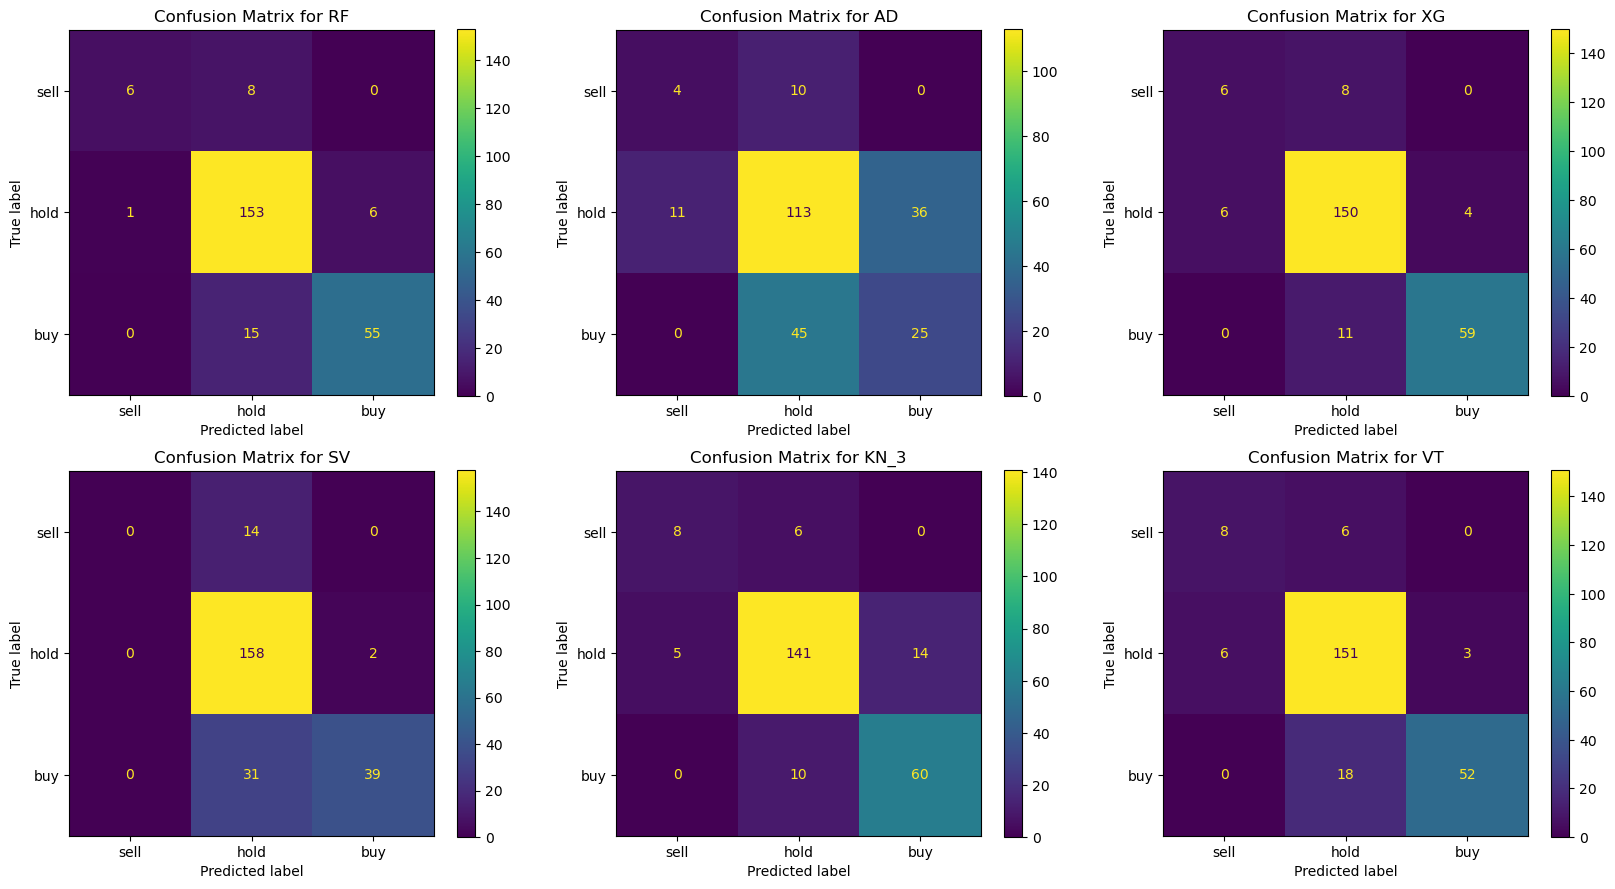

In [130]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10.5))
i = 0

for key, val in scores_dict.items():
    ax[int(i/3), i%3].set_title(f'Confusion Matrix for {key.upper()}')
    ConfusionMatrixDisplay(val[2], display_labels=disp_labels).plot(ax=ax[int(i/3), i%3])
    i += 1
    
plt.show()

In [131]:
train_target.value_counts()

target_50
1    648
2    241
0     86
Name: count, dtype: int64

In [132]:
test_target.value_counts()

target_50
1    160
2     70
0     14
Name: count, dtype: int64

In [133]:
vt_pred = all_results[0][2][-1][1]
train_df, test_df = train_test_split(x, test_size=0.2,  random_state=0)
train_df = train_df.assign(type='train')
train_df = train_df.assign(ground_truth=list(train_target))
train_df = train_df.assign(prediction=np.nan)
test_df = test_df.assign(type='test')
test_df = test_df.assign(ground_truth=list(test_target))
test_df = test_df.assign(prediction=vt_pred)

result_df = pd.concat([train_df, test_df])
result_df.reset_index(inplace=True)
result_df

,datetime,open,high,low,close,volume,SMA_5,EMA_5,SMA_10,EMA_10,...,UPPERBAND,MIDDLEBAND,LOWERBAND,negative,positive,total_news,sentiment,type,ground_truth,prediction
0,2022-06-08,4112.5,4212.5,4075.0,4200.0,153409200.0,4125.0,4140.481215,4091.25,4104.177606,...,4236.858449,4036.250,3835.641551,0.0,3.0,3.0,2,train,1,NaN
1,2020-12-18,3400.0,3412.5,3350.0,3350.0,142797800.0,3377.5,3377.015143,3366.25,3358.195105,...,3466.804984,3310.625,3154.445016,0.0,3.0,3.0,2,train,1,NaN
2,2022-06-13,4000.0,4050.0,3975.0,4050.0,122467200.0,4140.0,4109.216656,4132.50,4105.030409,...,4251.312866,4043.125,3834.937134,0.0,2.0,2.0,2,train,1,NaN
3,2022-12-30,5000.0,5025.0,4962.5,4962.5,40655800.0,4987.5,4980.188410,4990.00,4993.097467,...,5328.877843,5043.125,4757.372157,0.0,3.0,3.0,2,train,1,NaN
4,2020-06-17,2550.0,2600.0,2445.0,2450.0,213944600.0,2422.5,2447.988414,2462.00,2417.129833,...,2744.937162,2277.500,1810.062838,0.0,2.0,2.0,2,train,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1214,2022-05-09,4312.5,4337.5,4162.5,4162.5,351637800.0,4207.5,4203.075329,4085.00,4123.066156,...,4326.005617,3976.875,3627.744383,2.0,14.0,16.0,2,test,1,1.0
1215,2021-07-14,2900.0,2912.5,2825.0,2850.0,59225200.0,2895.0,2884.032526,2912.50,2906.151168,...,3107.615089,2953.125,2798.634911,0.0,3.0,3.0,2,test,1,1.0
1216,2022-06-28,4075.0,4100.0,4000.0,4062.5,97265000.0,4095.0,4095.857752,4110.00,4102.083254,...,4233.081346,4121.250,4009.418654,0.0,3.0,3.0,2,test,1,1.0
1217,2019-10-30,3537.5,3537.5,3487.5,3512.5,47667200.0,3535.0,3513.386957,3476.25,3475.983965,...,3624.966595,3361.875,3098.783405,4.0,5.0,9.0,2,test,1,1.0


### Save Results

In [134]:
try:
    os.makedirs(f"Result Machine Learning/{EMITEN}")
except Exception:
    pass
result_df.to_csv(f'Result Machine Learning/{EMITEN}/{EMITEN}_Target_{TARGET_DAY}.csv')

## Ensemble Result

In [3]:
# calculate RMSE
MODEL_LIST = ['Price Prediction', 'Deep Learning', 'Machine Learning']
TARGET_DAYS = [TARGET_DAY]

ensemble_results_dir = f'Ensemble Result/{EMITEN}'
if not os.path.exists(ensemble_results_dir):
    os.makedirs(ensemble_results_dir)

result_file_path = f'{ensemble_results_dir}/{EMITEN}_Target_{TARGET_DAY}_Results.csv'
header_results = f'emiten,model_type,target_day,accuracy,precision,recall,f1_score'
# with open(result_file_path, 'w') as writer:
#     writer.write(f'{header_results}\n')

all_predictions = []
for MODEL in MODEL_LIST:
    for TARGET_DAY in TARGET_DAYS:
        if MODEL == 'Price Prediction':
            data_path = f'Result {MODEL}/{EMITEN}/LSTM_{EMITEN}_Target_{TARGET_DAY}.csv'
        else:
            data_path = f'Result {MODEL}/{EMITEN}/{EMITEN}_Target_{TARGET_DAY}.csv'
    
        result_df = pd.read_csv(data_path)
        test_df = result_df[result_df['type'] == 'test']
        testCategoryPredict = test_df['prediction'].values
        testCatY = test_df['ground_truth'].values

        test_acc = round(accuracy_score(list(testCatY), testCategoryPredict), 4)
        test_prec = round(precision_score(list(testCatY), testCategoryPredict, average='weighted', zero_division=0), 4)
        test_rec = round(recall_score(list(testCatY), testCategoryPredict, average='weighted', zero_division=0), 4)
        test_f1 = round(f1_score(list(testCatY), testCategoryPredict, average='weighted', zero_division=0), 4)

        test_results = f'{EMITEN},{MODEL},{TARGET_DAY},{test_acc},{test_prec},{test_rec},{test_f1}'

        # with open(result_file_path, 'a') as writer:
            # writer.write('{}\n'.format(test_results))
        all_predictions.append(testCategoryPredict)
        print(f'{MODEL} Target {TARGET_DAY} Done')

Price Prediction Target 50 Done
Deep Learning Target 50 Done
Machine Learning Target 50 Done


In [4]:
total_ensemble = len(TARGET_DAYS)
ensemble_preds = np.zeros([all_predictions[0].shape[0], total_ensemble])
ensemble_preds.shape

np_all_prediction = all_predictions[0]
np_all_prediction = np_all_prediction.reshape([-1, 1])

## concat all prediction
for preds in all_predictions[1:]:
    np_all_prediction = np.hstack((np_all_prediction, preds.reshape([-1, 1])))

# concat prediction for same targe dat
for i in range(total_ensemble):
    for j in range(np_all_prediction.shape[0]):
        target = 'None'
        tmp = np_all_prediction[j]
        
        # find prediction for the same target day
        tmp = (tmp[i + (total_ensemble * 0)], tmp[i + (total_ensemble * 1)], tmp[i + total_ensemble * 2])
        label = Counter(tmp).most_common()[0]
        if label[1] == 1:
            label = 1
        else:
            label = label[0]
        ensemble_preds[j, i] = label

ensemble_preds[:5]

array([[2.],
       [1.],
       [1.],
       [1.],
       [2.]])

In [5]:
result_df = pd.read_csv(data_path)
for i in range(total_ensemble):
    result_df = pd.read_csv(data_path)
    test_df = result_df[result_df['type'] == 'test']
    testCatY = test_df['ground_truth'].values
    testCategoryPredict = ensemble_preds[:, i]

    test_acc = round(accuracy_score(list(testCatY), testCategoryPredict), 4)
    test_prec = round(precision_score(list(testCatY), testCategoryPredict, average='weighted', zero_division=0), 4)
    test_rec = round(recall_score(list(testCatY), testCategoryPredict, average='weighted', zero_division=0), 4)
    test_f1 = round(f1_score(list(testCatY), testCategoryPredict, average='weighted', zero_division=0), 4)

    test_results = f'{EMITEN},Ensemble Model,{TARGET_DAYS[i]},{test_acc},{test_prec},{test_rec},{test_f1}'

    # with open(result_file_path, 'a') as writer:
        # writer.write('{}\n'.format(test_results))

In [6]:
tmp = pd.read_csv(result_file_path)
tmp

,emiten,model_type,target_day,accuracy,precision,recall,f1_score
0,BMRI,Price Prediction,50,0.8443,0.8531,0.8443,0.8464
1,BMRI,Deep Learning,50,0.9344,0.9387,0.9344,0.9353
2,BMRI,Machine Learning,50,0.8648,0.8698,0.8648,0.8626
3,BMRI,Ensemble Model,50,0.9221,0.9237,0.9221,0.9223


# Visualization

In [7]:
df_result = pd.read_csv(f'Result Price Prediction/{EMITEN}/LSTM_{EMITEN}_Target_50.csv')
df_result = df_result.drop(df_result.columns[0], axis=1)
df_result = df_result[df_result['type'] == 'test']
df_result = df_result[['datetime', 'close', 'prediction']]
df_result['datetime'] = pd.to_datetime(df_result['datetime'])
df_result['prediction'] = ensemble_preds[:, -1]
df_result = df_result.sort_values(by='datetime')
df_result = df_result.set_index('datetime')

new_vis = pd.read_csv(f'Labelled Stock Data/Labelled_Stock_{EMITEN}.csv')
new_vis = new_vis.iloc[50:]
new_vis = new_vis[['datetime', 'close']]
new_vis['datetime'] = pd.to_datetime(new_vis['datetime'])
new_vis = new_vis.set_index('datetime')

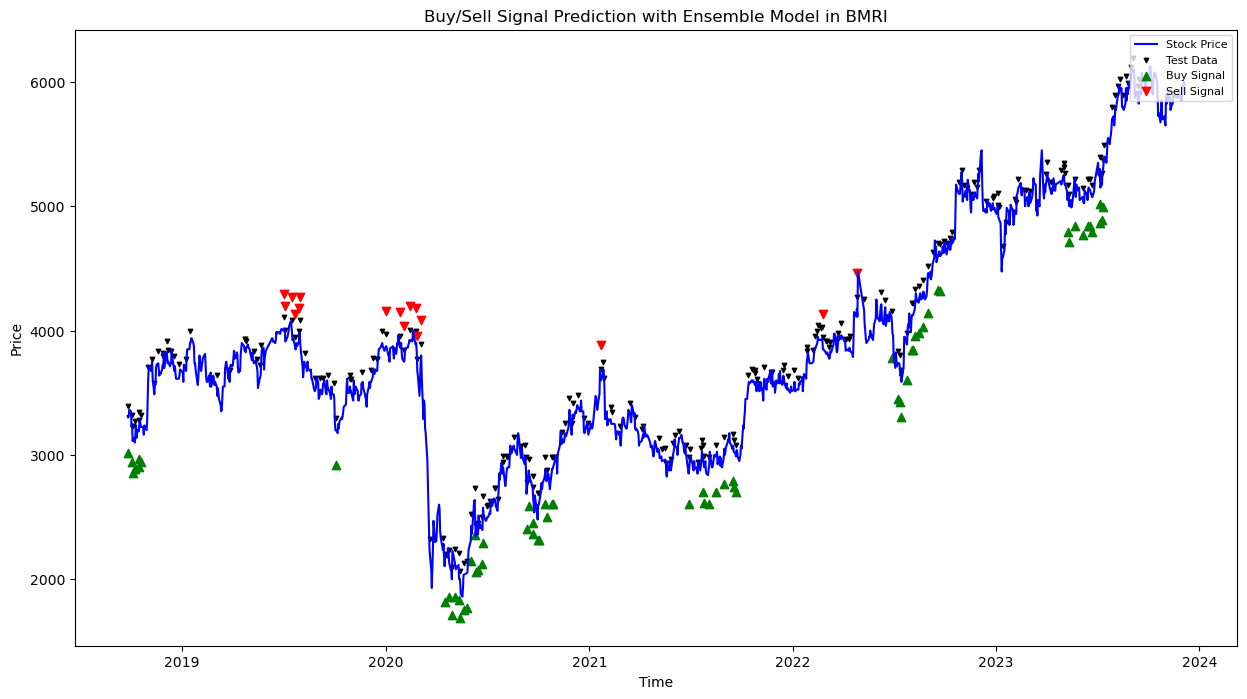

In [8]:
import matplotlib.pyplot as plt

padding = (new_vis['close'].max() - new_vis['close'].min()) / 15

buy_signal = df_result[df_result['prediction'] == 2]
sell_signal = df_result[df_result['prediction'] == 0]


plt.figure(figsize=(15, 8))
plt.plot(new_vis.index, new_vis["close"], color='blue') # For stock price
plt.scatter(df_result.index, df_result["close"] + (padding/3), color='black', marker="v", s=10) # For data test marker
plt.scatter(buy_signal.index, buy_signal["close"] - padding, color='green', marker="^") # For buy signal
plt.scatter(sell_signal.index, sell_signal["close"] + padding, color='red', marker="v") # For sell signal
plt.legend(['Stock Price', 'Test Data','Buy Signal', 'Sell Signal'], loc='upper right', fontsize=8)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'Buy/Sell Signal Prediction with Ensemble Model in {EMITEN}')
plt.show()